This notebook has been developed for a code-along introductory seminar on using [brightway](https://docs.brightway.dev/en/latest/). You can a more complete guide on brightway [here](https://learn.brightway.dev/en/latest/content/notebooks/BW25_for_beginners.html).

More information on the seminars can be found [here](https://adelinejerome.github.io/seminars-for-esa/).

# Importing packages

As [presented in the introductory seminar](https://adelinejerome.github.io/seminars-for-esa/seminar_intro.html), python resources are organised in packages, i.e., groups of objects and functions that can be used. One example is brightway. You have installed the packages in a [python environment](https://adelinejerome.github.io/seminars-for-esa/python.html#managing-python-virtual-environments). But now you must indicate to python that you want to load specific packages that you will be using in your code. You do it with `import name-package`.

Later in your code, when you want to use a function from `name-package`, you will have to write `name-package.function` which can be a bit long to type if the name of the package is long... So you can decide to import the package with a "nickname", usually very short, with `import name-package as pk`. With this, you will only have to write `pk.function` to use the function `function` from the package `name-package`.

Brightway is not *one* package but a group of several with different functions. Let's import them with their respective nickname!

In [1]:
import bw2data as bd
import bw2io as bi
import bw2calc as bc
import bw2analyzer as bwa

Additionally, we import two other packages:

- `pandas` for manipulating tables,
- `matplotlib` for generating figures.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Set up your project

The structure of information is similar to the Activity Browser. The information is structured in different projects, which contains several databases. To get the list of existing projects, use:

In [3]:
bd.projects

Brightway2 projects manager with 13 objects:
	ABB case
	Electric motors
	Motor case
	New motor case
	ab_demo
	ab_demo_solution
	brightway2_test
	brightway_demo
	default
	lca_algebraic_handbook
	lifetime_test
	motor_case
	pLCA course
Use `projects.report()` to get a report on all projects.

To see which project is currenly loaded:

In [4]:
bd.projects.current

'default'

To load another project or to create a new project if the project name is not already in the list of exiting projects:

In [5]:
bd.projects.set_current("brightway2_test")

To delete a project, use `bd.projects.delete_project`but it returns an error if the project does not exist. With the function below, it tries to delete a project but does nothing if an error is returned.

In [6]:
def reset_brightway_project(project_name):
    try:
        bd.projects.delete_project(project_name, True)
    except ValueError:
        pass

# Manage and import databases

To see the list of databases in the current project, use:

In [7]:
bd.databases

Databases dictionary with 3 object(s):
	biosphere3
	ecoinvent_391_cutoff
	motor_case

## Import the "biosphere" database

The *biosphere* database is containing the elementary flows necessary for ecoinvent. To load it as well as the impact assessment methods implemented with ecoinvent, use:

In [8]:
bi.bw2setup()

Biosphere database already present!!! No setup is needed


To search activities in a database or manipulate a database, you need to refer to the database "object". Here, the biosphere database is saved as `biosphere_db`.

In [9]:
biosphere_db = bd.Database("biosphere3")

## Import ecoinvent

When the biosphere database is imported, the ecoinvent database can be imported as well. The importer uses the folder "datasets" from the extracted files of the .7z file which can be fount on the [ecoinvent website](https://ecoquery.ecoinvent.org). Report the path of this folder below.

**!!!** Be careful that the path is with "/" instead of "\\"

In [10]:
path_datasets = "C:/Users/jeromea/Downloads/ecoinvent_3.9.1_cutoff_ecoSpold02/datasets"

The name of the imported database will be:

In [11]:
ei_db_name = "ecoinvent_391_cutoff"

After checking that the same database is not imported twice, the import is done is several steps:

1. First, all the datasets are loaded with `bi.SingleOutputEcospold2Importer`,
2. Then, the data are changed based on several "strategies" which are functions to modify the data,
3. You can check that things went well with `statistics()`, especially that there is "0 unlinked exchanges"
4. Finally, the database, for now only in the memory for your python session, is saved to your computer with `write_database()`

In [12]:
if ei_db_name in bd.databases:
    print("Database has already been imported.")
else:
    ei_importer = bi.SingleOutputEcospold2Importer(path_datasets, ei_db_name)
    ei_importer.apply_strategies()
    ei_importer.statistics() 
    ei_importer.write_database()

Database has already been imported.


You can see all the metadata (i.e., the properties for describing the database) of the imported database with:

In [13]:
bd.databases[ei_db_name]

{'overwrite': False,
 'format': 'Ecoinvent XML',
 'depends': ['biosphere3'],
 'backend': 'sqlite',
 'number': 21238,
 'modified': '2023-12-07T08:54:59.923322',
 'searchable': True,
 'processed': '2023-12-07T09:00:42.261022'}

Again, save the database "object" to easily search and get activities from it:

In [14]:
ei_db = bd.Database(ei_db_name)

# Manual creation of a database

Now that we know enough about databases, activities and exchanges, let's create our own database.

## Create the database

As errors can happen but as everything is available to re-write the database, it is convenient sometimes to re-start from zero. Here is a function to delete a database if it exists in the current project:

In [15]:
def reset_brightway_database(db_name):
    if db_name in bd.databases:
        del bd.databases[db_name]

To create a new database, create a database "object" with a name, and then save it on your computer with `register`:

In [16]:
name_motor_db = "motor_case"
reset_brightway_database(name_motor_db)
motor_db = bd.Database(name_motor_db)
motor_db.register()

Let's check that it was created:

In [17]:
bd.databases

Databases dictionary with 3 object(s):
	biosphere3
	ecoinvent_391_cutoff
	motor_case

## Add activities

As for databases, it is convenient to be able to delete an activity to re-start from zero. Here is a function for that:

In [18]:
def reset_activity(act_name, database=motor_db):
    for activity in [act for act in motor_db if act['name']==act_name]:
        activity.delete()

In [19]:
def create_new_activity(act_name, unit, exchanges, database=motor_db):
    reset_activity(act_name, database)
    act_new = motor_db.new_activity(
        name = act_name,
        code = act_name,
        unit = unit
    )
    act_new.save()
    for input, amount in exchanges:
        act_new.new_exchange(
            input = input,
            amount = amount,
            type = "technosphere"
        ).save()
    act_new.save()

**Inputs from ecoinvent**

First, let get the necessary activities from ecoinvent:

In [20]:
code_steel_unalloyed = ei_db.search("market for steel, unalloyed GLO")[0]["code"]

In [21]:
act_steel_unalloyed = ei_db.get(code_steel_unalloyed)

In [22]:
code_steel_low_alloyed = ei_db.search("market for steel, low-alloyed GLO")[0]["code"]

In [23]:
act_steel_low_alloyed = ei_db.get(code_steel_low_alloyed)

In [24]:
code_copper = ei_db.search("market for copper, cathode GLO")[0]["code"]

In [25]:
act_copper = ei_db.get(code_copper)

In [26]:
code_insulation = ei_db.search("market for epoxy resin, liquid RER")[0]["code"]

In [27]:
act_insulation = ei_db.get(code_insulation)

In [28]:
code_elec = ei_db.search("market for electricity, high voltage SE")[0]["code"]

In [29]:
act_elec = ei_db.get(code_elec)

In [30]:
code_incineration_insulation = ei_db.search("treatment of waste plastic, mixture, municipal incineration with fly ash extraction CH")[0]["code"]

In [31]:
act_incineration_insulation = ei_db.get(code_incineration_insulation)

In [32]:
code_incineration_copper = ei_db.search("treatment of copper in car shredder residue, municipal incineration with fly ash extraction CH")[0]["code"]

In [33]:
act_incineration_copper = ei_db.get(code_incineration_copper)

**Parameters**

Then the value of different parameters useful to create the activities.

In [62]:
qt_steel_unalloyed = 26600 #kg
qt_steel_low_alloyed = 4100 #kg
qt_copper = 3600 #kg
qt_insulation = 400*100 #kg
weight_motor = qt_steel_unalloyed + qt_steel_low_alloyed + qt_copper + qt_insulation
output_power = 16000 #kW
op_hours = 8400 #hours per year
lifetime = 20 #years
efficiency = 0.973

**Activities creation**

With our own function `create_new_activity`, creating an activity looks like that:

In [63]:
def create_motor_production(qt_steel_unalloyed=qt_steel_unalloyed, qt_steel_low_alloyed=qt_steel_low_alloyed, qt_copper=qt_copper, qt_insulation=qt_insulation):
    create_new_activity(
        "motor production",
        "unit",
        [
            (act_steel_unalloyed, qt_steel_unalloyed),
            (act_steel_low_alloyed, qt_steel_low_alloyed),
            (act_copper, qt_copper),
            (act_insulation, qt_insulation),
            (act_elec, 3600)
        ]
    )

When activity creation is scattered in the code, it is practical to turn it as functions. When each activity creation is under a function, a last function can call all of them in the right order. Then, you are sure that all your created database is updated.

In the creation functions, you can also add input parameters to be able to change them quickly.

Let's do this for all activities in the life cycle of a motor.

In [64]:
def create_motor_testing():
    create_new_activity(
        "motor testing",
        "unit",
        [
            (motor_db.get("motor production"), 1),
            (act_elec, 16000)
        ]
    )

In [65]:
def create_motor_use(lifetime=lifetime, efficiency=efficiency):
    create_new_activity(
        "motor use",
        "unit",
        [
            (motor_db.get("motor testing"), 1),
            (act_elec, output_power*op_hours*lifetime*(1/efficiency-1))
        ]
    )

In [66]:
def create_motor_treatment(weight_motor=weight_motor, qt_insulation=qt_insulation, qt_copper=qt_copper):
    create_new_activity(
        "motor EoL treatment",
        "unit",
        [
            (motor_db.get("motor use"), 1),
            (act_elec, 0.041*weight_motor),
            (act_incineration_insulation, -qt_insulation),
            (act_incineration_copper, -0.04*qt_copper)
        ]
    )

And now a function to call all the functions which creates activities:

In [67]:
def create_motor_system(
    qt_steel_unalloyed=qt_steel_unalloyed, 
    qt_steel_low_alloyed=qt_steel_low_alloyed, 
    qt_copper=qt_copper, 
    qt_insulation=qt_insulation, 
    lifetime=lifetime, 
    efficiency=efficiency, 
    weight_motor=weight_motor
):
    create_motor_production(qt_steel_unalloyed=qt_steel_unalloyed, qt_steel_low_alloyed=qt_steel_low_alloyed, qt_copper=qt_copper, qt_insulation=qt_insulation)
    create_motor_testing()
    create_motor_use(lifetime=lifetime, efficiency=efficiency)
    create_motor_treatment(weight_motor=weight_motor, qt_insulation=qt_insulation, qt_copper=qt_copper)

In [68]:
create_motor_system()

To check the activities in the database:

In [69]:
[act for act in motor_db]

['motor use' (unit, GLO, None),
 'motor production' (unit, GLO, None),
 'motor EoL treatment' (unit, GLO, None),
 'motor testing' (unit, GLO, None)]

# First LCA calculation

## Selection of impact assessment methods

Methods can be selected when knowing the tuple for their name:

In [70]:
gw_method = ('EF v3.1', 'climate change', 'global warming potential (GWP100)')

Or by selecting the items in a list:

In [71]:
csi_method = [method for method in bd.methods if "Crustal" in str(method)][0]

## Impact assessment

The impact assessment is divided in several steps. First, the functional unit is defined as a dictionary {activity: amount}.

In [72]:
def lca_results(fu, list_methods):
    list_units = [bd.methods.get(method)["unit"] for method in list_methods]
    lca = bc.LCA(demand=fu, method=list_methods[0])
    lca.lci()
    lca.lcia()
    list_scores = [lca.score]
    for method in list_methods[1:]:
        lca.switch_method(method)
        lca.lcia()
        list_scores.append(lca.score)
    return pd.DataFrame({"score": list_scores, "unit": list_units, "method": list_methods})

In [73]:
functional_unit = {motor_db.get("motor EoL treatment"): 1/lifetime}
lca_results(functional_unit, [gw_method, csi_method])

,score,unit,method
0,1.407050e+05,kg CO2-Eq,"(EF v3.1, climate change, global warming poten..."
1,2.637203e+07,kg Si-Eq,"(Crustal Scarcity Indicator 2020, material res..."


## Customised contribution analysis

Here I provide functions for contribution analysis for the processes in the created database:

In [74]:
def table_recursive_multi_calculation_dbparent_cut(activity, lcia_methods, amount=1, level=0, max_level=3, db_parent=None, db_cut=['ecoinvent'], act_parent={"name": None}):
    """
    Returns a table (DataFrame) with the contribution tree for a given activity and various LCIA methods.
    The contribution tree does not contain sub-activities if the activity is from a database in db_cut (to avoid 
    having details on ecoinvent datasets and to stay in my own model) and has the maximum level max_level.
    Columns for the returned table: level, activity, activity parent, database parent, and str(method) for all LCIA method explored.
    """
    
    lca_score = lca_results({activity: amount}, lcia_methods)
    table = pd.DataFrame([[level, activity["name"], act_parent["name"], db_parent]+ list(lca_score["score"])], columns=["level", "activity", "activity parent", "database parent"]+[str(m) for m in lcia_methods])
    if level < max_level:
        db_parent = activity['database']
        go_forward = True
        for stop_word in db_cut:
            if stop_word in db_parent:
                go_forward = False
        if go_forward:
            for exc in activity.technosphere():
                table = pd.concat([table, table_recursive_multi_calculation_dbparent_cut(
                    activity=exc.input, 
                    lcia_methods=lcia_methods, 
                    amount=amount * exc['amount'], 
                    level=level + 1, 
                    max_level=max_level,
                    db_parent = db_parent,
                    act_parent = activity
                )], ignore_index=True)
    return table

In [75]:
def table_recursive_multi_calculation_dbcut(activity, lcia_methods, amount=1, level=0, max_level=3, db_activity='motor_case', db_cut=['ecoinvent', 'biosphere']):
    """
    Returns a table (DataFrame) with the contribution tree for a given activity and various LCIA methods.
    The contribution tree does not contain activities if they are from a database in db_cut (to avoid 
    having details on ecoinvent datasets and to stay in my own model) and has the maximum level max_level.
    Columns for the returned table: level, activity, database, and str(method) for all LCIA method explored.
    """
    
    lca_score = lca_results({activity: amount}, lcia_methods)
    table = pd.DataFrame([[level, activity["name"], db_activity]+ list(lca_score["score"])], columns=["level", "activity", "database"]+[str(m) for m in lcia_methods])
    if level < max_level:
        for exc in activity.technosphere():
            db_exc = exc.input['database']
            go_forward = True
            for stop_word in db_cut:
                if stop_word in db_exc:
                    go_forward = False
            if go_forward:
                table = pd.concat([table, table_recursive_multi_calculation_dbcut(
                    activity=exc.input, 
                    lcia_methods=lcia_methods, 
                    amount=amount * exc['amount'], 
                    level=level + 1, 
                    max_level=max_level,
                    db_activity = db_exc
                )], ignore_index=True)
    return table

## Figures

Here is a way to generate a box plot figure.

In [76]:
own_colors = {
    "motor production":"#1f78b4", #blue
    "motor use":"#969696", #gray
    "motor EoL treatment": "#41ae76", #green
    "motor testing":"#fff7bc" #yellow
}

In [77]:
table_results = table_recursive_multi_calculation_dbcut(
    activity = motor_db.get("motor EoL treatment"), 
    lcia_methods=[gw_method, csi_method], 
    amount = 1/lifetime,
    max_level = 3
)

In [78]:
def basic_bar_chart(table_results, legend_x_axis, own_colors=own_colors):
    table_figure = table_results.set_index(table_results["activity"])
    number_methods = table_figure.shape[1] - 3

    fig, ax = plt.subplots(1, number_methods)
    x_axis = [0]

    for n_fig, method in enumerate(table_figure.columns[3:]):
        for activity in table_figure.index:
            if n_fig == 0:
                ax[n_fig].bar(
                    x_axis, 
                    table_figure.loc[activity, method], 
                    label=activity, 
                    color=own_colors[activity]
                )
            else:
                ax[n_fig].bar(
                    x_axis, 
                    table_figure.loc[activity, method], 
                    color=own_colors[activity]
                )
    
    fig.tight_layout()
    for n_fig in range(number_methods):
        ax[n_fig].grid(True, axis='y', linewidth=0.4)
        ax[n_fig].set_xticks(x_axis)
        ax[n_fig].set_xticklabels([legend_x_axis[n_fig]], fontsize=14)
    
    fig.legend(loc='lower center', ncol=5)
    plt.subplots_adjust(bottom=0.15)
    
    return plt.show()

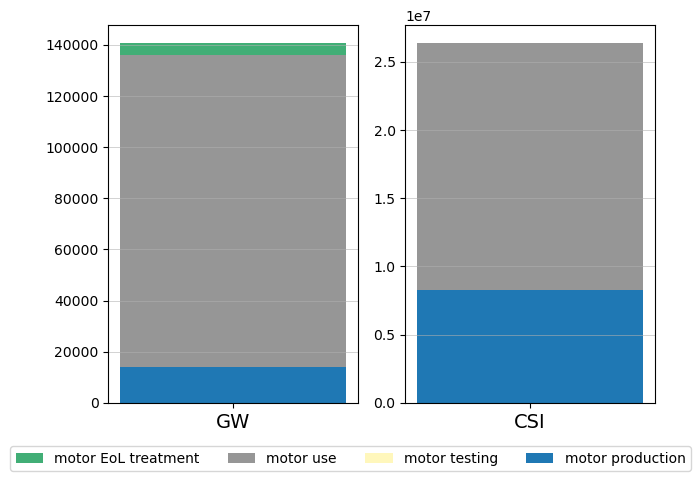

In [79]:
basic_bar_chart(
    table_results,
    ["GW", "CSI"]
)

# Different scenarios

## Data

In [80]:
data_low_efficiency = {
    "qt_steel_unalloyed": 26600, #kg
    "qt_steel_low_alloyed": 4100, #kg
    "qt_copper": 3600, #kg
    "qt_insulation": 400, #kg
    "weight_motor": 26600+4100+3600+400, #kg
    "lifetime": 20, #years
    "efficiency": 0.973
}

In [81]:
data_high_efficiency = {
    "qt_steel_unalloyed": 18000, #kg
    "qt_steel_low_alloyed": 9200, #kg
    "qt_copper": 3800, #kg
    "qt_insulation": 300, #kg
    "weight_motor": 18000+9200+3800+300, #kg
    "lifetime": 20, #years
    "efficiency": 0.9835
}

In [82]:
data_repair_low_efficiency = {
    "qt_steel_unalloyed": 26600, #kg
    "qt_steel_low_alloyed": 4100, #kg
    "qt_copper": 3600*1.5, #kg
    "qt_insulation": 400*1.5, #kg
    "weight_motor": 26600+4100+3600*1.5+400*1.5, #kg
    "lifetime": 40, #years
    "efficiency": 0.973
}

In [83]:
data_repair_high_efficiency = {
    "qt_steel_unalloyed": 18000, #kg
    "qt_steel_low_alloyed": 9200, #kg
    "qt_copper": 3800*1.5, #kg
    "qt_insulation": 300*1.5, #kg
    "weight_motor": 18000+9200+3800*1.5+300*1.5, #kg
    "lifetime": 40, #years
    "efficiency": 0.9835
}

## Generation of results

In [84]:
dict_scenarios = {
    "low efficiency": data_low_efficiency, 
    "high efficiency": data_high_efficiency, 
    "repair low efficiency": data_repair_low_efficiency, 
    "repair high efficiency": data_repair_high_efficiency
}

In [85]:
def return_table_results_scenarios(dict_scenarios, methods=[gw_method, csi_method]):
    results_table = pd.DataFrame()
    for name, data in dict_scenarios.items():
        create_motor_system(**data)
        functional_unit = {motor_db.get("motor EoL treatment"): 1/data["lifetime"]}
        results_table_scenario = lca_results(functional_unit, methods)
        results_table_scenario["scenario"] = name
        results_table = pd.concat([results_table, results_table_scenario], ignore_index=True)
    return results_table

In [86]:
table_results_scenarios = return_table_results_scenarios(dict_scenarios)

In [87]:
table_results_scenarios

,score,unit,method,scenario
0,1.261332e+05,kg CO2-Eq,"(EF v3.1, climate change, global warming poten...",low efficiency
1,2.419240e+07,kg Si-Eq,"(Crustal Scarcity Indicator 2020, material res...",low efficiency
2,7.768787e+04,kg CO2-Eq,"(EF v3.1, climate change, global warming poten...",high efficiency
3,1.736572e+07,kg Si-Eq,"(Crustal Scarcity Indicator 2020, material res...",high efficiency
4,1.243726e+05,kg CO2-Eq,"(EF v3.1, climate change, global warming poten...",repair low efficiency
5,2.258877e+07,kg Si-Eq,"(Crustal Scarcity Indicator 2020, material res...",repair low efficiency
6,7.605343e+04,kg CO2-Eq,"(EF v3.1, climate change, global warming poten...",repair high efficiency
7,1.567980e+07,kg Si-Eq,"(Crustal Scarcity Indicator 2020, material res...",repair high efficiency


## Figures

In [88]:
def figure_comparison_scenarios(table_results_scenarios, legend_x_axis):
    number_methods = 2

    fig, ax = plt.subplots(1, number_methods)
    x_axis = [i for i in range(len(dict_scenarios))]

    for index in table_results_scenarios.index:
        ax[index%2].bar(x_axis[index//2], table_results_scenarios.loc[index, "score"])
    
    fig.tight_layout()
    for n_fig in range(number_methods):
        ax[n_fig].grid(True, axis='y', linewidth=0.4)
        ax[n_fig].set_xticks(x_axis)
        ax[n_fig].set_xticklabels(legend_x_axis, rotation=90)
        ax[n_fig].set_ylabel(table_results_scenarios.loc[n_fig, "unit"])

    plt.subplots_adjust(wspace=0.3)
    
    return plt.show()

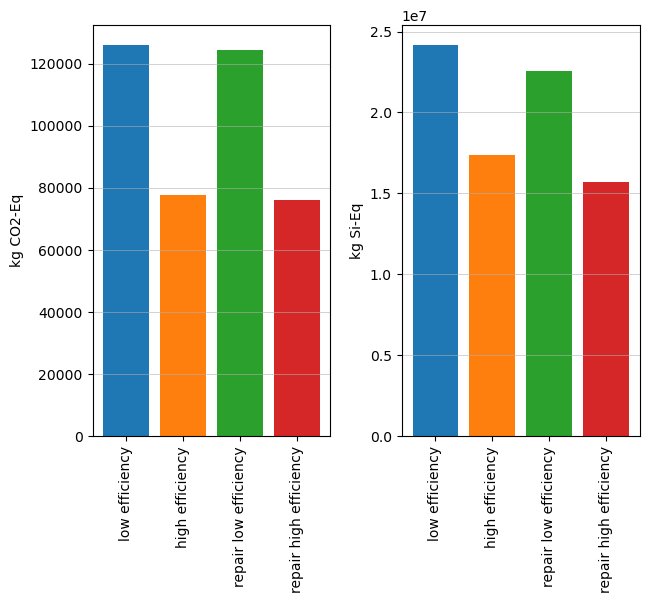

In [89]:
figure_comparison_scenarios(table_results_scenarios, list(dict_scenarios.keys()))